In [4]:
#upgrading tensorflow to latest version
pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [5]:
#unziping the data.zip file to access data
from zipfile import ZipFile
file_name = 'derma_disease_dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Extraction Done")

Extraction Done


In [0]:
# Import Keras with tensorflow backend
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16

# Import OpenCV
import cv2

# Utility
import os
import numpy as np
import itertools
import random
from collections import Counter
from glob import iglob

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

# Plot
import matplotlib.pyplot as plt
%matplotlib inline 

In [0]:
# Set dataset folder path
BASE_DATASET_FOLDER = os.path.join("derma_disease_dataset","dataset")
TRAIN_FOLDER = "train"
VALIDATION_FOLDER = "validation"
TEST_FOLDER = "test"

# VGG16 image size
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

# Keras settings
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 0.0001
MODEL_PATH = os.path.join("derma_disease_detection_VGG16_fine_tuned_colab.h5")

In [8]:
#Loading and performing Data augmentation on training data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TRAIN_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=TRAIN_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=True)

Found 938 images belonging to 3 classes.


In [9]:
#Loading and performing Data augmentation on validation data
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, VALIDATION_FOLDER),
        target_size=IMAGE_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 97 images belonging to 3 classes.


In [10]:
#Loading and performing Data augmentation on test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=VAL_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 368 images belonging to 3 classes.


In [11]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratosis'}


In [12]:
#Loading VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
#Freezing the layers except last 4 layers
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

In [0]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

In [15]:
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3

In [0]:
#Compiling the model using adam optimizer and learning rate as taken above
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

In [17]:
#training the model
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=val_generator.samples//val_generator.batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 14 steps, validate for 3 steps
Epoch 1/10
14/14 [==============================] - 25s 2s/step - loss: 1.1089 - acc: 0.4188 - val_loss: 0.8944 - val_acc: 0.5729
Epoch 2/10
14/14 [==============================] - 11s 784ms/step - loss: 0.9332 - acc: 0.5801 - val_loss: 0.8288 - val_acc: 0.6458
Epoch 3/10
14/14 [==============================] - 11s 781ms/step - loss: 0.8286 - acc: 0.6396 - val_loss: 0.7478 - val_acc: 0.6667
Epoch 4/10
14/14 [==============================] - 11s 800ms/step - loss: 0.7585 - acc: 0.6864 - val_loss: 0.6528 - val_acc: 0.7083
Epoch 5/10
14/14 [==============================] - 11s 787ms/step - loss: 0.7191 - acc: 0.7014 - val_loss: 0.6290 - val_acc: 0.7188
Epoch 6/10
14/14 [==============================] - 11s 808ms/step - loss: 0.6882 - acc: 0.7277 - val_loss: 0.6343 - val_acc: 0.7292
Epoch 7/10
14/14 [====================

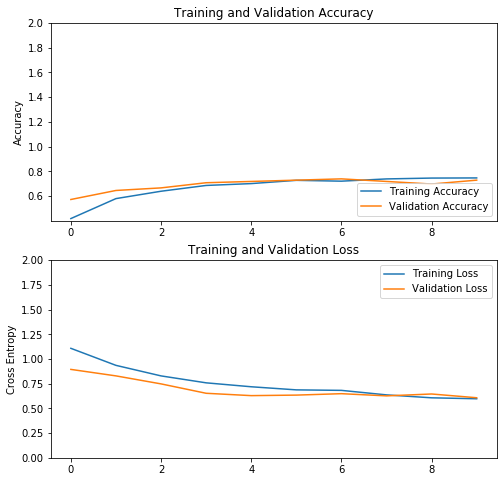

In [18]:
#plotting Learning curves for the built model
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 2])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 2.0])
plt.title('Training and Validation Loss')

plt.show()

In [0]:
#fine tuning the built model to achieve more accuracy
fine_tune_at = 7
for layer in vgg_model.layers[:fine_tune_at]:
    layer.trainable = False

In [0]:
#Compiling the model using adam optimizer and lower learning rate than that taken above
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE/10),
              metrics=['acc'])

In [0]:
#assigning initial epochs
initial_epochs = EPOCHS

In [22]:
#training the model (fine tuning it)
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=total_epochs,
        initial_epoch = history.epoch[-1],
        validation_data=val_generator,
        validation_steps=val_generator.samples//val_generator.batch_size)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 14 steps, validate for 3 steps
Epoch 10/20
14/14 [==============================] - 12s 845ms/step - loss: 0.5361 - acc: 0.7883 - val_loss: 0.6315 - val_acc: 0.7396
Epoch 11/20
14/14 [==============================] - 11s 765ms/step - loss: 0.5389 - acc: 0.7757 - val_loss: 0.6206 - val_acc: 0.7188
Epoch 12/20
14/14 [==============================] - 11s 807ms/step - loss: 0.5276 - acc: 0.7803 - val_loss: 0.6221 - val_acc: 0.7708
Epoch 13/20
14/14 [==============================] - 11s 793ms/step - loss: 0.4908 - acc: 0.8135 - val_loss: 0.6416 - val_acc: 0.7604
Epoch 14/20
14/14 [==============================] - 12s 853ms/step - loss: 0.5048 - acc: 0.8066 - val_loss: 0.6281 - val_acc: 0.7708
Epoch 15/20
14/14 [==============================] - 11s 810ms/step - loss: 0.4747 - acc: 0.8204 - val_loss: 0.6453 - val_acc: 0.7708
Epoch 16/20
14/14 [==============================] - 11s 803ms/step - loss: 0.4741 - acc: 0.8158 - val_lo

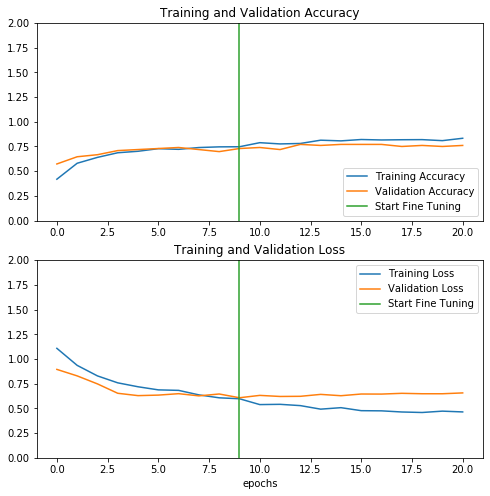

In [23]:
#plotting Learning curves for the built model adding fine tune to it
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.ylim([0, 2])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.show()

In [0]:
#saving the built model
model.save(MODEL_PATH)

In [25]:
#testing the model
%%time
loss, accuracy = model.evaluate_generator(test_generator,steps=test_generator.samples//test_generator.batch_size)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
CPU times: user 1.85 s, sys: 581 ms, total: 2.44 s
Wall time: 3.69 s


In [26]:
print("Accuracy: %f\nLoss: %f" % (accuracy,loss))

Accuracy: 0.701087
Loss: 0.749330


In [0]:
#Function to load random images
def load_image(filename):
    img = cv2.imread(os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img

#Function to predict the class of the image loaded/passed to it
def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: seborrheic_keratosis, file: seborrheic_keratosis/ISIC_0012772.jpg
PREDICTED: class: seborrheic_keratosis, confidence: 0.453453


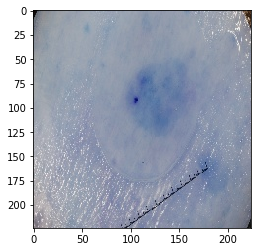

<Figure size 432x288 with 0 Axes>

SOURCE: class: nevus, file: nevus/ISIC_0013288.jpg
PREDICTED: class: nevus, confidence: 0.672080


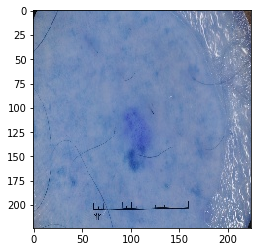

SOURCE: class: melanoma, file: melanoma/ISIC_0013079.jpg
PREDICTED: class: melanoma, confidence: 0.780375


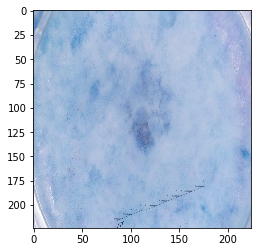

<Figure size 432x288 with 0 Axes>

SOURCE: class: seborrheic_keratosis, file: seborrheic_keratosis/ISIC_0014651.jpg
PREDICTED: class: seborrheic_keratosis, confidence: 0.958048


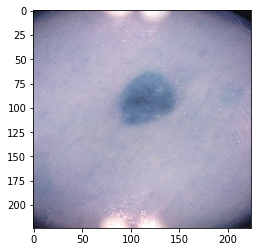

<Figure size 432x288 with 0 Axes>

SOURCE: class: melanoma, file: melanoma/ISIC_0014187.jpg
PREDICTED: class: nevus, confidence: 0.469480


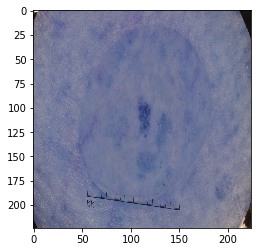

<Figure size 432x288 with 0 Axes>

SOURCE: class: melanoma, file: melanoma/ISIC_0014766.jpg
PREDICTED: class: melanoma, confidence: 0.998549


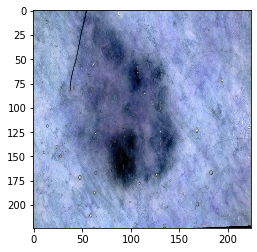

<Figure size 432x288 with 0 Axes>

SOURCE: class: melanoma, file: melanoma/ISIC_0013455.jpg
PREDICTED: class: melanoma, confidence: 0.556542


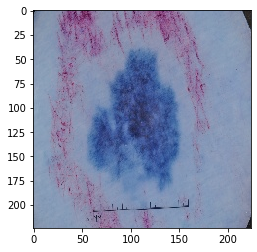

<Figure size 432x288 with 0 Axes>

SOURCE: class: nevus, file: nevus/ISIC_0012303.jpg
PREDICTED: class: nevus, confidence: 0.804686


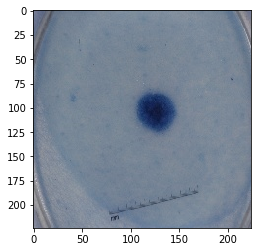

<Figure size 432x288 with 0 Axes>

SOURCE: class: melanoma, file: melanoma/ISIC_0014092.jpg
PREDICTED: class: nevus, confidence: 0.381022


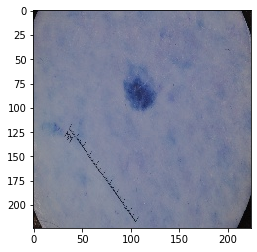

<Figure size 432x288 with 0 Axes>

SOURCE: class: melanoma, file: melanoma/ISIC_0013411.jpg
PREDICTED: class: melanoma, confidence: 0.585531


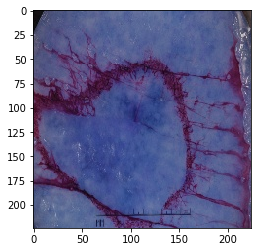

<Figure size 432x288 with 0 Axes>

In [28]:
#Loading random sample images from test dataset and predicting them
for idx, filename in enumerate(random.sample(test_generator.filenames, 10)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()